## FKA122: H2a | Jonatan Haraldsson & Oscar Stommendal - Group 19

### Import statements, constants and general functions

In [100]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=20)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Constants
k_B = K.Boltzmann
e = K.elementary_charge
k_B /= e
n_atoms = 256

# Functions
def read_data(task, T, its_eq=0, its=0):
    if task == 2:
        if its_eq:
            eq_facts = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', max_rows=1, delimiter=',', dtype=np.float64)
            eq_data = np.genfromtxt(f'data/task_2/equilibrium_{its_eq}_{T}.csv', delimiter=',', dtype=np.float64)[1:, :]
        else:
            eq_facts = None
            eq_data = None
        if its:
            atoms_data = np.genfromtxt(f'data/task_2/lattice/atoms_{its_eq}_{its}_{T}.csv')
            energy_facts = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', max_rows=2, delimiter=',', dtype=np.float64)[1]
            energy_data = np.genfromtxt(f'data/task_2/energy_{its_eq}_{its}_{T}.csv', delimiter=',', dtype=np.float64, skip_header=3)
        else:
            atoms_data = None
            energy_facts = None
            energy_data = None
    
    return eq_data, eq_facts, atoms_data, energy_data, energy_facts


### Task 1 - Temperature dependence of $P$, $U$ and $C_V$ using Mean Field Theory

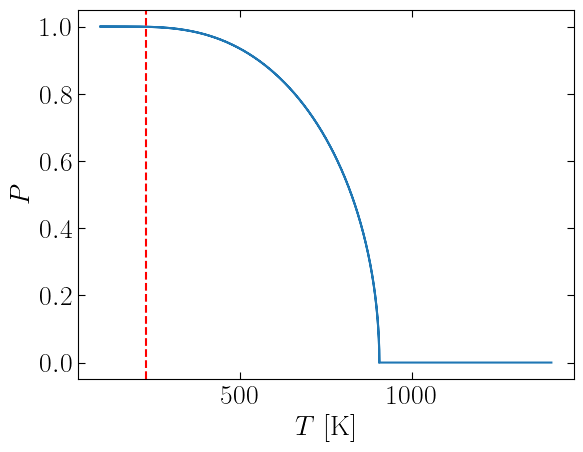

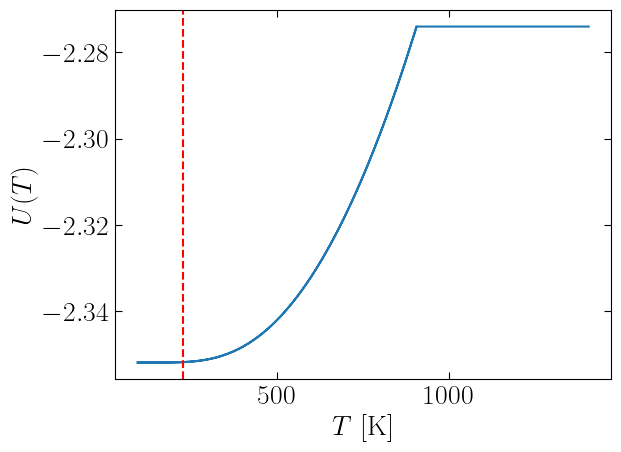

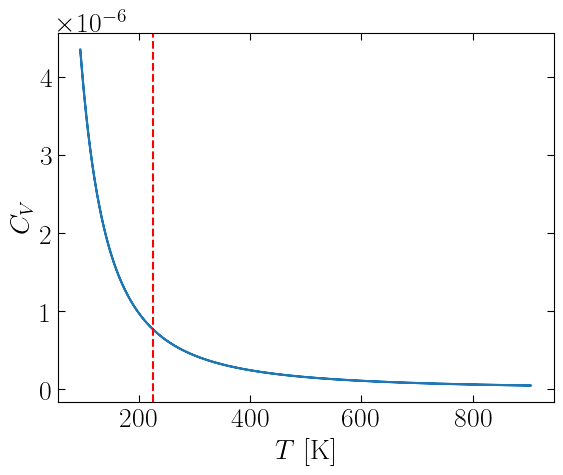

In [31]:

path = 'data/task_1/P_T.csv'
data = np.loadtxt(path, delimiter=',')

E_cucu = -0.436
E_znzn = -0.113
E_cuzn = -0.294
delta_E = E_cucu + E_znzn - 2*E_cuzn
T_c = 0.5*delta_E/k_B
T_over_Tc = np.linspace(np.max(data[:, 1]), np.max(data[:, 1]) + 500, 10000)

plt.figure()
plt.plot(data[:,1],abs(data[:,0]))
plt.plot(T_over_Tc, np.zeros(len(T_over_Tc)), 'tab:blue')
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$P$')

u_T = 2*(E_cucu + E_znzn + 2*E_cuzn)*np.ones(len(data[:,1])) - 2*data[:,0]**2*delta_E
plt.figure()
plt.plot(data[:,1],u_T)
plt.plot(T_over_Tc, np.ones(len(T_over_Tc))*2*(E_cucu + E_znzn + 2*E_cuzn), 'tab:blue')
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$U(T)$')

u_fluct = np.mean(u_T**2) - np.mean(u_T)**2
c_V = u_fluct / (k_B * data[:,1]**2)
plt.figure()
plt.plot(data[:,1],c_V)
plt.axvline(x=T_c, color='r', linestyle='--')
plt.xlabel('$T$ [K]')
plt.ylabel('$C_V$')

plt.show()

### Task 2 - Calculating $U$ using the Metropolis Algorithm 

In [101]:

its_eq_400 = 200000
its_eq = 100000
its = 1000000

# data_eq_400, eq_facts_400 , _, _, _ = read_data(2, 400, its_eq=its_eq_400)
# data_eq_600, eq_facts_600 , _, _, _ = read_data(2, 600, its_eq=its_eq)
# data_eq_1000, eq_facts_1000 , _, _, _ = read_data(2, 1000, its_eq=its_eq)

# fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(data_eq_400[:, 0])
# axs[1].plot(data_eq_400[:, 1])
# axs[0].set_ylabel('Accepted steps')
# axs[1].set_ylabel('Potential energy')
# axs[1].set_xlabel('MC steps')

# fig, axs = plt.subplots(2, 1, sharex=True)
# axs[0].plot(energy_data[:, 0])
# axs[1].plot(energy_data[:, 1])
# axs[0].set_ylabel('Accepted steps')
# axs[1].set_ylabel('Potential energy')
# axs[1].set_xlabel('MC steps')

# plt.tight_layout()
# plt.show()

_, _, atoms_data_400, energy_data_400, energy_facts_400 = read_data(2, 400, its_eq=its_eq_400, its=its)
_, _, atoms_data_600, energy_data_600, energy_facts_600 = read_data(2, 600, its_eq=its_eq, its=its)
_, _, atoms_data_1000, energy_data_1000, energy_facts_1000 = read_data(2, 1000, its_eq=its_eq, its=its)

accept_400_eq = energy_facts_400[1]
accept_600_eq = energy_facts_600[1]
accept_1000_eq = energy_facts_1000[1]
Epot_400 = np.mean(energy_data_400[:, 1])
Epot_600 = np.mean(energy_data_600[:, 1])
Epot_1000 = np.mean(energy_data_1000[:, 1])

df = pd.DataFrame({'T': [400, 600, 1000], 'Epot': [Epot_400, Epot_600, Epot_1000], 
                   'N_eq': [its_eq_400, its_eq, its_eq], 'Acceptance_eq': [accept_400_eq, accept_600_eq, accept_1000_eq]})
display(df)


,T,Epot,N_eq,Acceptance_eq
0,400,-583.909018,200000,0.018165
1,600,-563.172920,100000,0.101110
2,1000,-520.629598,100000,0.592380


### Task 3

#### a) Temperature dependence of $U$, $C_V$, $P$ and $r$ using MFT

#### b) Error estimation using block average and autocorrelation